<a href="https://colab.research.google.com/github/Ash100/Minor/blob/main/Embeddings_ESM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Enable GPU
!nvidia-smi

# ✅ Install dependencies
!pip install transformers umap-learn hdbscan biopython scikit-learn matplotlib seaborn fair-esm

In [4]:
from Bio import SeqIO

fasta_path = "/content/ncbi_refseq_with_lxxll_motif_motif_patches.fasta"
motif_seqs = [(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")]
print(f"Loaded {len(motif_seqs)} motifs")

Loaded 378 motifs


In [5]:
import torch
from esm import pretrained

model, alphabet = pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [6]:
embeddings = []

# Batch size can be tuned based on memory
batch_size = 32
for i in range(0, len(motif_seqs), batch_size):
    batch = motif_seqs[i:i+batch_size]
    labels, strs, tokens = batch_converter(batch)

    with torch.no_grad():
        results = model(tokens, repr_layers=[33], return_contacts=False)
    reps = results["representations"][33]

    for j, (_, seq) in enumerate(batch):
        emb = reps[j, 1:len(seq)+1].mean(0)  # mean pooling
        embeddings.append(emb.numpy())

In [7]:
#@title Dimentionality Reduction
import umap
import numpy as np

X = np.array(embeddings)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(X)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Clustering Benchmark Script for ESM2 Embeddings

In [11]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import pandas as pd

In [12]:
#@title Evaluation Function
def evaluate_clustering(X, labels):
    unique = np.unique(labels)
    if len(unique) <= 1 or (len(unique) == 2 and -1 in unique):
        return {"Silhouette": None, "DB": None, "CH": None}
    return {
        "Silhouette": silhouette_score(X, labels),
        "DB": davies_bouldin_score(X, labels),
        "CH": calinski_harabasz_score(X, labels)
    }


In [14]:
# Example: if you used UMAP
X_reduced = X_umap  # or whatever variable holds your reduced embeddings


In [15]:
#@title Run Clustering Methods
results = {}
labels_dict = {}

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_reduced)
labels_dict["KMeans"] = kmeans.labels_
results["KMeans"] = evaluate_clustering(X_reduced, kmeans.labels_)

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=5).fit(X_reduced)
labels_dict["Agglomerative"] = agglo.labels_
results["Agglomerative"] = evaluate_clustering(X_reduced, agglo.labels_)

# Spectral
spectral = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42).fit(X_reduced)
labels_dict["Spectral"] = spectral.labels_
results["Spectral"] = evaluate_clustering(X_reduced, spectral.labels_)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_reduced)
labels_dict["DBSCAN"] = dbscan.labels_
results["DBSCAN"] = evaluate_clustering(X_reduced, dbscan.labels_)

# HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=5).fit(X_reduced)
labels_dict["HDBSCAN"] = hdb.labels_
results["HDBSCAN"] = evaluate_clustering(X_reduced, hdb.labels_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
#@title Display Result
df_results = pd.DataFrame(results).T
df_results = df_results.round(4)
print(df_results.sort_values("Silhouette", ascending=False))

               Silhouette      DB        CH
Spectral           0.4829  0.4755  494.3701
KMeans             0.4705  0.6256  645.5620
Agglomerative      0.4585  0.6399  624.3239
HDBSCAN            0.4086  0.3431   88.2246
DBSCAN             0.2649  1.7288  397.5854


/tmp/ipython-input-3203532850.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.index, y=df_results["Silhouette"], palette="viridis")


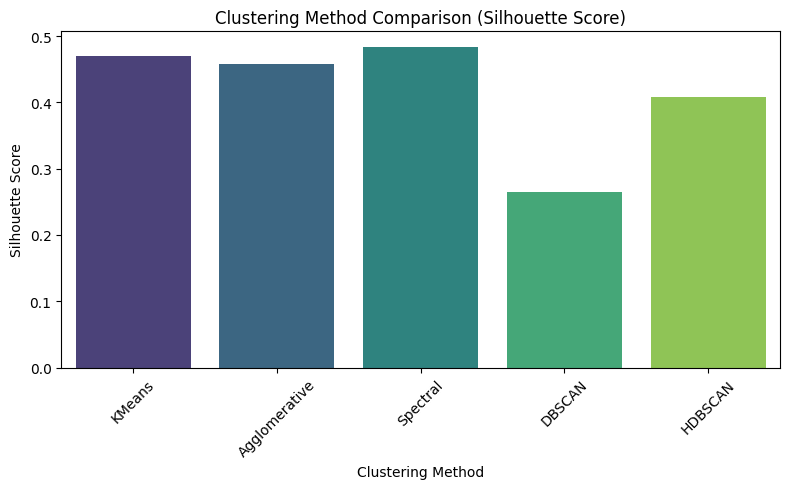

In [25]:
#@title Cluster Bechmarkings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_results is your benchmark DataFrame
# Save to CSV
df_results.to_csv("clustering_benchmark.csv", index=True)

# Plot Silhouette scores
plt.figure(figsize=(8, 5))
sns.barplot(x=df_results.index, y=df_results["Silhouette"], palette="viridis")
plt.title("Clustering Method Comparison (Silhouette Score)")
plt.ylabel("Silhouette Score")
plt.xlabel("Clustering Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Benmarch_clustering_silhouette_scores.png", dpi=800)
plt.show()


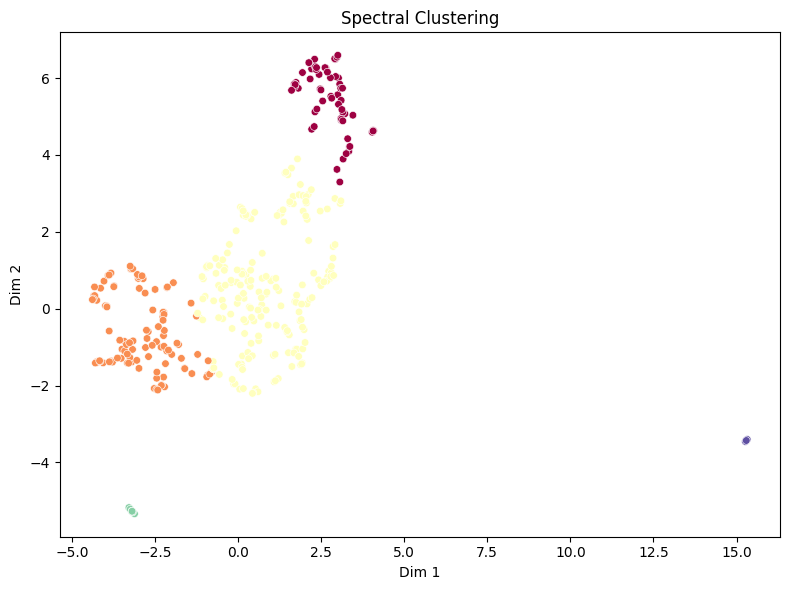

In [17]:
#@title Visualize Best Result
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(X, labels, title="Clustering Result"):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels, palette="Spectral", s=30, legend=False)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

# Example: visualize best method
best_method = df_results["Silhouette"].idxmax()
plot_clusters(X_reduced, labels_dict[best_method], title=f"{best_method} Clustering")

In [8]:
#@title Clustering (HDBSCAN)
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer.fit_predict(X_umap)

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


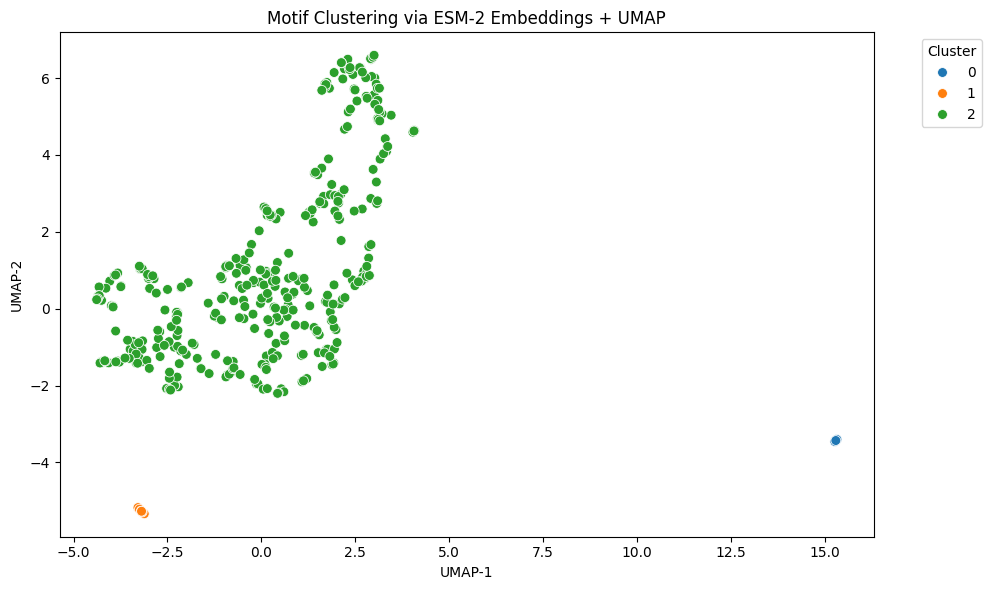

In [9]:
#@title Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette='tab10', s=50)
plt.title("Motif Clustering via ESM-2 Embeddings + UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

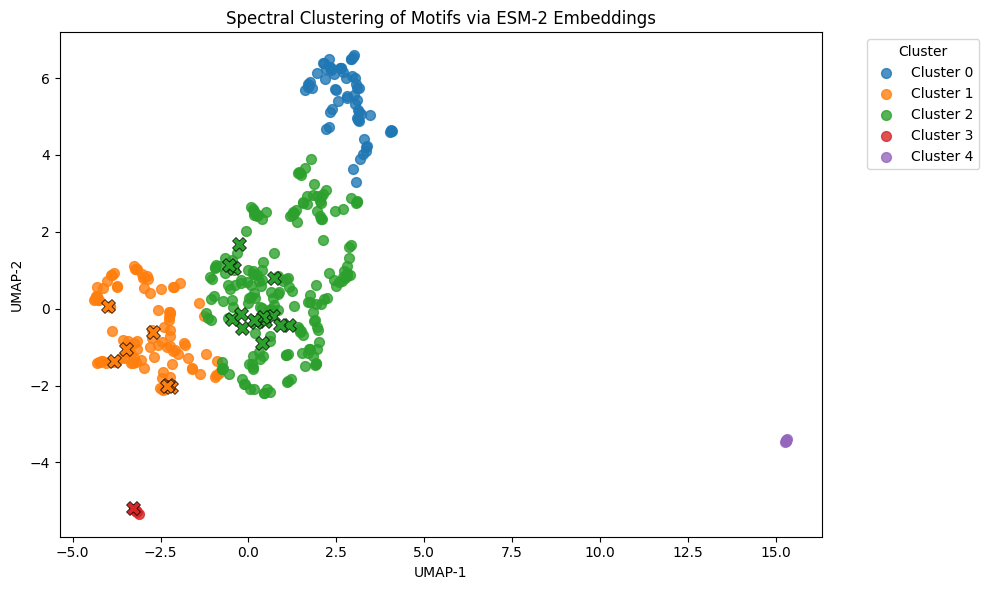

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define control prefixes
control_prefixes = ("NCOA1", "NCOA2", "NCOA3", "NCOA4", "CBP", "MED1", "PGC1")

# Identify control nodes
is_control = np.array([any(name.startswith(prefix) for prefix in control_prefixes) for name, _ in motif_seqs])

# Use Spectral clustering labels
spectral_labels = labels_dict["Spectral"]

# Prepare plot
plt.figure(figsize=(10, 6))

# Get unique cluster labels (excluding noise -1)
unique_labels = sorted(set(spectral_labels) - {-1})
palette = sns.color_palette('tab10', n_colors=len(unique_labels))
label_to_color = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot non-control motifs by cluster
for label in unique_labels:
    idx = (spectral_labels == label) & (~is_control)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        c=[label_to_color[label]],
        s=50,
        label=f"Cluster {label}",
        alpha=0.8
    )

# Plot noise cluster (-1) if present
if -1 in spectral_labels:
    idx = (spectral_labels == -1) & (~is_control)
    if np.any(idx):
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c='lightgray',
            s=50,
            label="Noise",
            alpha=0.5
        )

# Overlay control motifs with same cluster color, distinct marker
for idx, (name, _) in enumerate(motif_seqs):
    label = spectral_labels[idx]
    if is_control[idx] and label != -1:
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c=[label_to_color[label]],
            marker='X',
            s=100,
            edgecolors='black',
            linewidths=0.5
        )
    elif is_control[idx] and label == -1:
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c='lightgray',
            marker='X',
            s=100,
            edgecolors='black',
            linewidths=0.5
        )

# Final touches
plt.title("Spectral Clustering of Motifs via ESM-2 Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save figure
plt.savefig("spectral_motif_clustering.png", dpi=800)
plt.show()


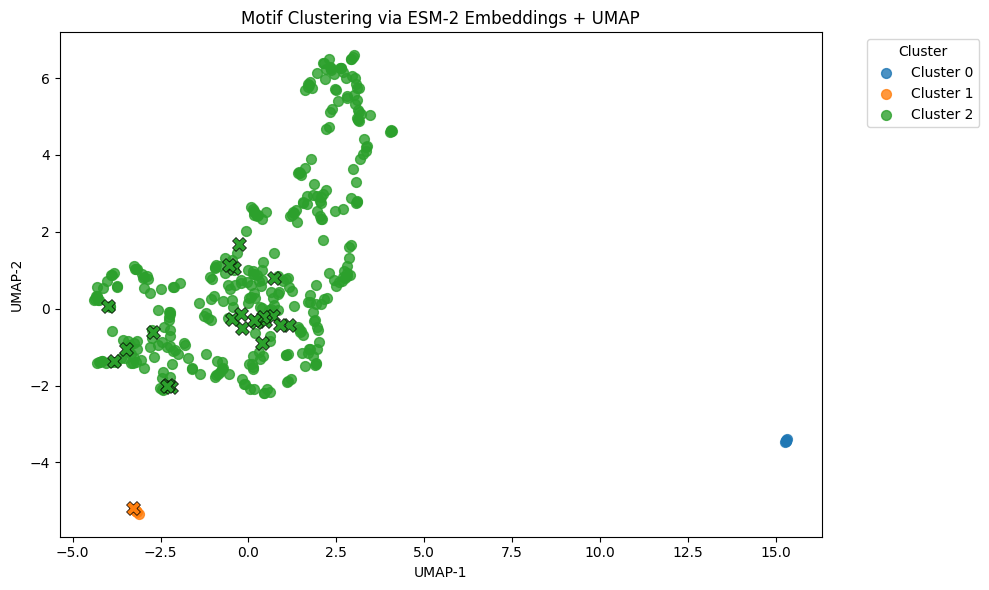

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define control prefixes
control_prefixes = ("NCOA1", "NCOA2", "NCOA3", "NCOA4", "CBP", "MED1", "PGC1")

# Identify control nodes
is_control = np.array([any(name.startswith(prefix) for prefix in control_prefixes) for name, _ in motif_seqs])

# Prepare plot
plt.figure(figsize=(10, 6))

# Get unique cluster labels (excluding noise -1)
unique_labels = sorted(set(labels) - {-1})
palette = sns.color_palette('tab10', n_colors=len(unique_labels))
label_to_color = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot non-control motifs by cluster
for label in unique_labels:
    idx = (labels == label) & (~is_control)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        c=[label_to_color[label]],
        s=50,
        label=f"Cluster {label}",
        alpha=0.8
    )

# Plot noise cluster (-1) if present
if -1 in labels:
    idx = (labels == -1) & (~is_control)
    if np.any(idx):
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c='lightgray',
            s=50,
            label="Noise",
            alpha=0.5
        )

# Overlay control motifs with same cluster color, distinct marker
for idx, (name, _) in enumerate(motif_seqs):
    if is_control[idx] and labels[idx] != -1:
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c=[label_to_color[labels[idx]]],
            marker='X',
            s=100,
            edgecolors='black',
            linewidths=0.5
        )
    elif is_control[idx] and labels[idx] == -1:
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            c='lightgray',
            marker='X',
            s=100,
            edgecolors='black',
            linewidths=0.5
        )

# Final touches
plt.title("Motif Clustering via ESM-2 Embeddings + UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save figure
plt.savefig("esm2_motif_clustering.png", dpi=800)
plt.show()

In [ ]:
#@title Evaluate Clustering Quality
from sklearn.metrics import silhouette_score, davies_bouldin_score

valid_idx = labels != -1
print("Silhouette Score:", silhouette_score(X_umap[valid_idx], labels[valid_idx]))
print("Davies-Bouldin Index:", davies_bouldin_score(X_umap[valid_idx], labels[valid_idx]))

Silhouette Score: 0.55103827
Davies-Bouldin Index: 0.4884388582558822


In [27]:
#@title Compute Nearest Neighbours
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(n_neighbors=5, metric='euclidean')
nn_model.fit(X_umap)
distances, indices = nn_model.kneighbors(X_umap)

In [28]:
#@title Compute Silhouette Scores (per motif)
from sklearn.metrics import silhouette_samples

valid_idx = labels != -1
sil_scores = np.full(len(labels), np.nan)
sil_scores[valid_idx] = silhouette_samples(X_umap[valid_idx], labels[valid_idx])


In [29]:
#@title Compute Cluster Centroids & Distances
from scipy.spatial.distance import euclidean

centroids = {}
for label in np.unique(labels):
    if label == -1:
        continue
    centroids[label] = X_umap[labels == label].mean(axis=0)

dist_to_centroid = [
    euclidean(X_umap[i], centroids[labels[i]]) if labels[i] != -1 else np.nan
    for i in range(len(labels))
]

In [30]:
#@title Build dataframe
import pandas as pd

df = pd.DataFrame({
    "Motif_ID": [name for name, _ in motif_seqs],
    "Cluster_Label": labels,
    "UMAP_1": X_umap[:, 0],
    "UMAP_2": X_umap[:, 1],
    "Is_Control": is_control,
    "Silhouette_Score": sil_scores,
    "Distance_to_Centroid": dist_to_centroid,
    "Nearest_Neighbors": [", ".join([motif_seqs[j][0] for j in idx]) for idx in indices]
})


In [31]:
df.to_csv("esm2_motif_metadata.csv", index=False)

In [32]:
#@title Clusterwise Data
df = pd.DataFrame({
    "Motif_ID": [name for name, _ in motif_seqs],
    "Cluster_Label": labels,
    "UMAP_1": X_umap[:, 0],
    "UMAP_2": X_umap[:, 1],
    "Is_Control": is_control,
    "Silhouette_Score": sil_scores,
    "Distance_to_Centroid": dist_to_centroid,
    "Nearest_Neighbors": [", ".join([motif_seqs[j][0] for j in idx]) for idx in indices]
})

In [33]:
#@title Export Each Cluster to Own CSV
import os

# Create output folder
os.makedirs("clusterwise_csv", exist_ok=True)

# Loop through unique clusters (excluding noise -1)
for cluster_id in sorted(set(labels)):
    if cluster_id == -1:
        continue  # Skip noise

    cluster_df = df[df["Cluster_Label"] == cluster_id]
    filename = f"esm2_clusterwise_csv/esm2_cluster_{cluster_id}.csv"
    cluster_df.to_csv(filename, index=False)
    print(f"Saved: {filename} ({len(cluster_df)} motifs)")

OSError: Cannot save file into a non-existent directory: 'esm2_clusterwise_csv'

In [34]:
#@title Noise Cluster
noise_df = df[df["Cluster_Label"] == -1]
noise_df.to_csv("esm2_clusterwise_csv/esm_noise_cluster.csv", index=False)
print(f"Saved: noise_cluster.csv ({len(noise_df)} motifs)")

OSError: Cannot save file into a non-existent directory: 'esm2_clusterwise_csv'

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

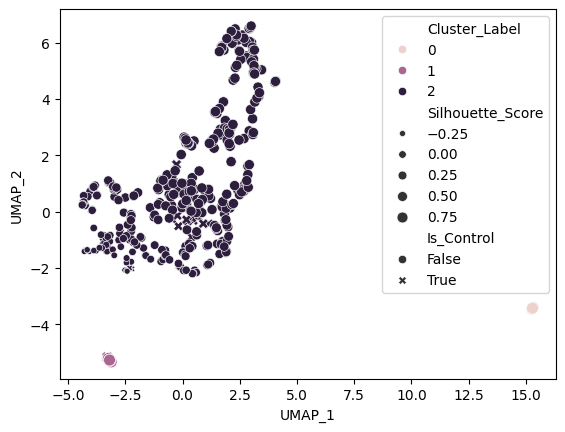

In [35]:
#@title Visualization Options
import seaborn as sns
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue="Cluster_Label", size="Silhouette_Score", style="Is_Control")

In [37]:
X_embedded = np.array(df[["UMAP_1", "UMAP_2"]])

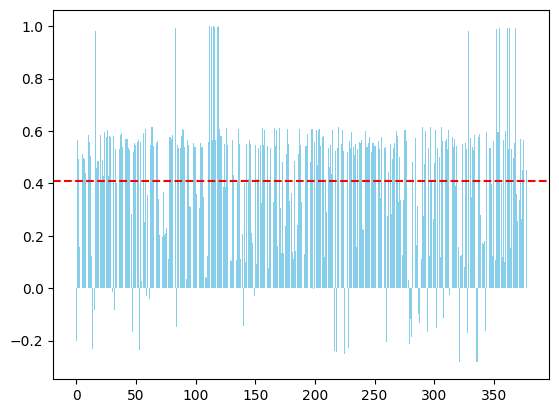

In [38]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt

sample_silhouette_values = silhouette_samples(X_embedded, labels)
plt.bar(range(len(sample_silhouette_values)), sample_silhouette_values, color='skyblue')
plt.axhline(y=np.mean(sample_silhouette_values), color='red', linestyle='--')

# Save figure
plt.savefig("esm2_motif_Silhoutte.png", dpi=800)
plt.show()


###What the Figure Shows<br>
X-axis: Each bar corresponds to a single motif (or data point).

Y-axis: The silhouette score for that motif, ranging from −1 to +1.

Bar height: Indicates how well the motif is clustered:

Close to +1 → tightly grouped with its cluster, far from others.

Around 0 → near the boundary between clusters.

Negative → possibly misclassified; closer to another cluster.

Red dashed line: The mean silhouette score across all motifs — a benchmark for overall clustering quality.

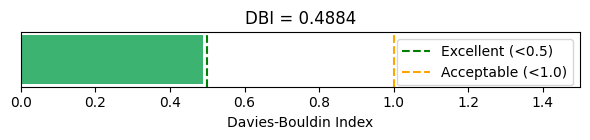

In [39]:
import matplotlib.pyplot as plt

# Your DBI value
dbi_value = 0.4884

# Thresholds
excellent = 0.5
acceptable = 1.0

# Plot
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.barh(y=0, width=dbi_value, color='mediumseagreen', height=0.4)
ax.axvline(x=excellent, color='green', linestyle='--', label='Excellent (<0.5)')
ax.axvline(x=acceptable, color='orange', linestyle='--', label='Acceptable (<1.0)')
ax.set_xlim(0, max(1.5, dbi_value + 0.2))
ax.set_yticks([])
ax.set_xlabel("Davies-Bouldin Index")
ax.set_title(f"DBI = {dbi_value:.4f}")
ax.legend(loc='upper right')
plt.tight_layout()

# Save figure
plt.savefig("esm2_Davies-Bouldin_index.png", dpi=800)
plt.show()
plt.show()


The chart shows your Davies-Bouldin Index (DBI) value of 0.4884 as a horizontal bar, with annotated thresholds:

🟢 < 0.5: Excellent — your clustering falls just inside this zone

🟠 0.5–1.0: Acceptable — moderate separation

🔴 > 1.0: Poor — overlapping clusters

Your DBI bar lands confidently in the excellent zone, reinforcing what your silhouette scores already suggested: your motif clusters are compact and well-separated.

In [43]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ✅ Define control prefixes
control_prefixes = ("NCOA1", "NCOA2", "NCOA3", "NCOA4", "CBP", "MED1", "PGC1")

# ✅ Identify control motifs
is_control = np.array([any(name.startswith(prefix) for prefix in control_prefixes) for name, _ in motif_seqs])

# ✅ Use Spectral clustering labels
spectral_labels = labels_dict["Spectral"]

# ✅ Separate controls and candidates
control_indices = np.where(is_control)[0]
candidate_indices = np.where(~is_control)[0]

control_names = [motif_seqs[i][0] for i in control_indices]
candidate_names = [motif_seqs[i][0] for i in candidate_indices]

control_vecs = np.array([embeddings[i] for i in control_indices])
candidate_vecs = np.array([embeddings[i] for i in candidate_indices])

# ✅ Compute cosine similarity
similarity_matrix = cosine_similarity(control_vecs, candidate_vecs)

# ✅ Collect results
rows = []
for i, control_name in enumerate(control_names):
    top_indices = similarity_matrix[i].argsort()[::-1][:10]
    for rank, idx in enumerate(top_indices, 1):
        candidate_idx = candidate_indices[idx]
        candidate_name = motif_seqs[candidate_idx][0]
        similarity = similarity_matrix[i][idx]
        cluster = spectral_labels[candidate_idx]
        rows.append({
            "Control": control_name,
            "Neighbor": candidate_name,
            "Similarity": round(similarity, 4),
            "Cluster": cluster,
            "Rank": rank
        })

# ✅ Save to CSV
df = pd.DataFrame(rows)
df.to_csv("top10_neighbors_with_clusters.csv", index=False)

print("✅ CSV saved: top10_neighbors_with_clusters.csv")


✅ CSV saved: top10_neighbors_with_clusters.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load data
df = pd.read_csv("/content/final_top10_neighbors_with_clusters.csv")

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 150

# 🎯 1. Average Similarity per Control Motif
plt.figure(figsize=(10, 5))
avg_sim = df.groupby("Control")["Similarity"].mean().sort_values(ascending=False)
sns.barplot(x=avg_sim.index, y=avg_sim.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Similarity to Neighbors")
plt.title("🔍 Control Motifs with Highest Average Similarity")
plt.tight_layout()
plt.savefig("avg_similarity_per_control.png")
plt.show()

# 📦 2. Boxplot of Similarity Scores by Cluster
plt.figure(figsize=(10, 5))
sns.boxplot(x="Cluster", y="Similarity", data=df, palette="Set2")
plt.title("📦 Similarity Distribution by Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Cosine Similarity")
plt.tight_layout()
plt.savefig("similarity_boxplot_by_cluster.png")
plt.show()

# 🔥 3. Heatmap of Control–Neighbor Similarity
pivot = df.pivot(index="Control", columns="Neighbor", values="Similarity")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="mako", linewidths=0.5, linecolor='gray')
plt.title("🔥 Control–Neighbor Similarity Heatmap")
plt.xlabel("Neighbor Motif")
plt.ylabel("Control Motif")
plt.tight_layout()
plt.savefig("control_neighbor_heatmap.png")
plt.show()

# 🎯 4. Scatter Plot: Rank vs Similarity Colored by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Rank", y="Similarity", hue="Cluster", palette="tab10", s=80, edgecolor="black")
plt.title("🎯 Similarity vs Rank (Colored by Cluster)")
plt.xlabel("Neighbor Rank")
plt.ylabel("Cosine Similarity")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("rank_vs_similarity_by_cluster.png")
plt.show()


/tmp/ipython-input-2348679715.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2348679715.py:24: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2348679715.py:25: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.savefig("similarity_boxplot_by_cluster.png", dpi=800, bbox_inches="tight")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


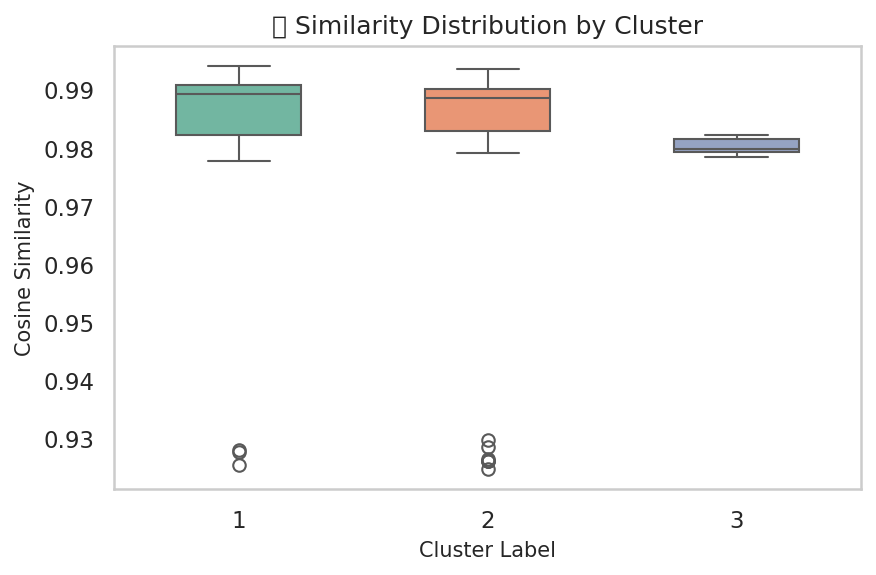

In [50]:
# 📦 2. Boxplot of Similarity Scores by Cluster (with outer box only)
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="Cluster",
    y="Similarity",
    data=df,
    palette="Set2",
    width=0.5
)

plt.title("📦 Similarity Distribution by Cluster", fontsize=12)
plt.xlabel("Cluster Label", fontsize=10)
plt.ylabel("Cosine Similarity", fontsize=10)

# 🔹 Remove grid lines and keep only the outer box
sns.despine(offset=0, trim=False)
plt.grid(False)

# Add full box around plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig("similarity_boxplot_by_cluster.png", dpi=800, bbox_inches="tight")
plt.show()


/tmp/ipython-input-2399749769.py:29: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2399749769.py:30: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig("control_neighbor_heatmap.png", dpi=800, bbox_inches="tight")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


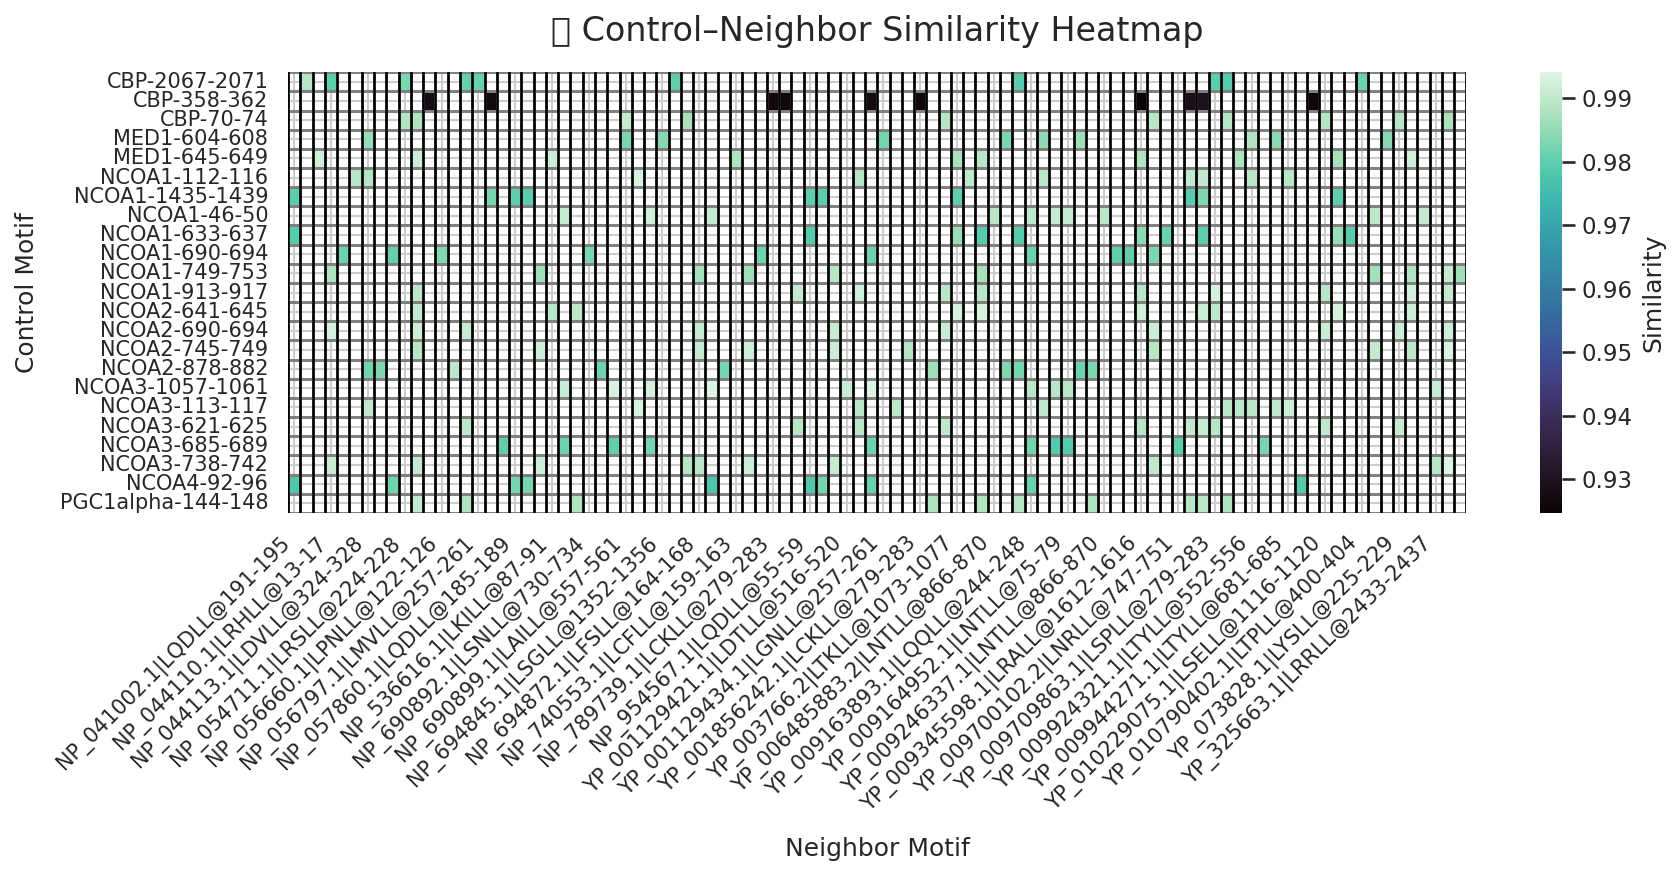

In [58]:
# 🔥 3. Heatmap of Control–Neighbor Similarity (with x-label boundary lines)
pivot = df.pivot(index="Control", columns="Neighbor", values="Similarity")

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    pivot,
    cmap="mako",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Similarity"}
)

# Titles and labels
ax.set_title("🔥 Control–Neighbor Similarity Heatmap", fontsize=16, pad=15)
ax.set_xlabel("Neighbor Motif", fontsize=12, labelpad=10)
ax.set_ylabel("Control Motif", fontsize=12, labelpad=10)

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# ✅ Add vertical boundary lines between x-label blocks
for x in range(len(pivot.columns) + 1):
    ax.axvline(x, color="black", linewidth=1.2)

# Optional: also horizontal boundary lines (between Controls)
# for y in range(len(pivot.index) + 1):
#     ax.axhline(y, color="black", linewidth=1.2)

plt.tight_layout()
plt.savefig("control_neighbor_heatmap.png", dpi=800, bbox_inches="tight")
plt.show()


/tmp/ipython-input-2827199601.py:8: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2827199601.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig("rank_vs_similarity_by_cluster.png", dpi=800, bbox_inches="tight")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


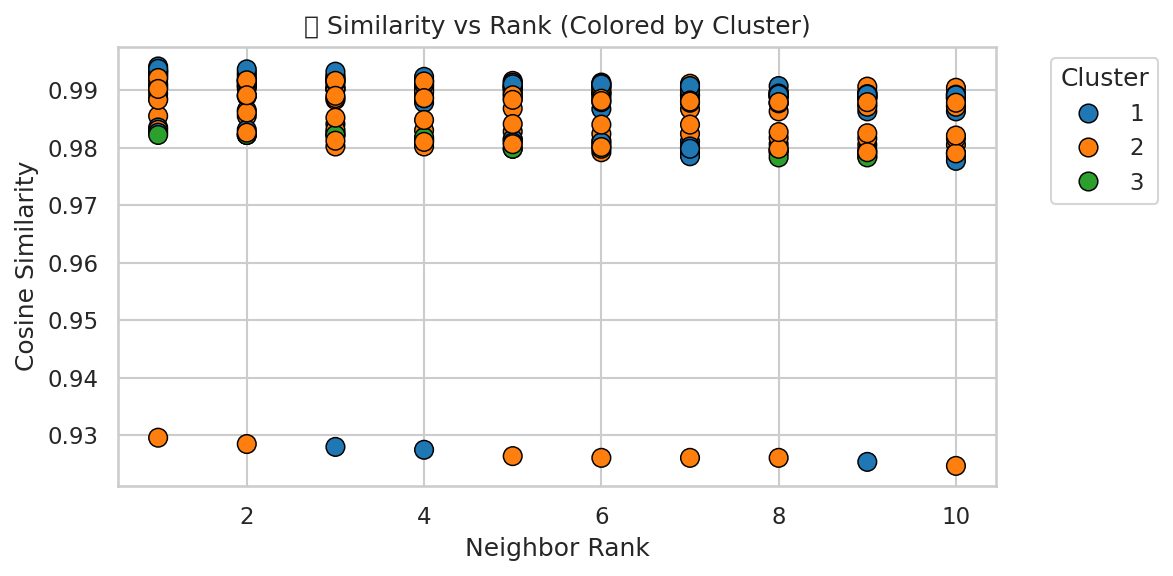

In [62]:
# 🎯 4. Scatter Plot: Rank vs Similarity Colored by Cluster
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x="Rank", y="Similarity", hue="Cluster", palette="tab10", s=80, edgecolor="black")
plt.title("🎯 Similarity vs Rank (Colored by Cluster)")
plt.xlabel("Neighbor Rank")
plt.ylabel("Cosine Similarity")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("rank_vs_similarity_by_cluster.png", dpi=800, bbox_inches="tight")
plt.show()

/tmp/ipython-input-22732013.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sim.index, y=avg_sim.values, palette="viridis")
/tmp/ipython-input-22732013.py:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-22732013.py:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("avg_similarity_per_control.png", dpi=800, bbox_inches="tight")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


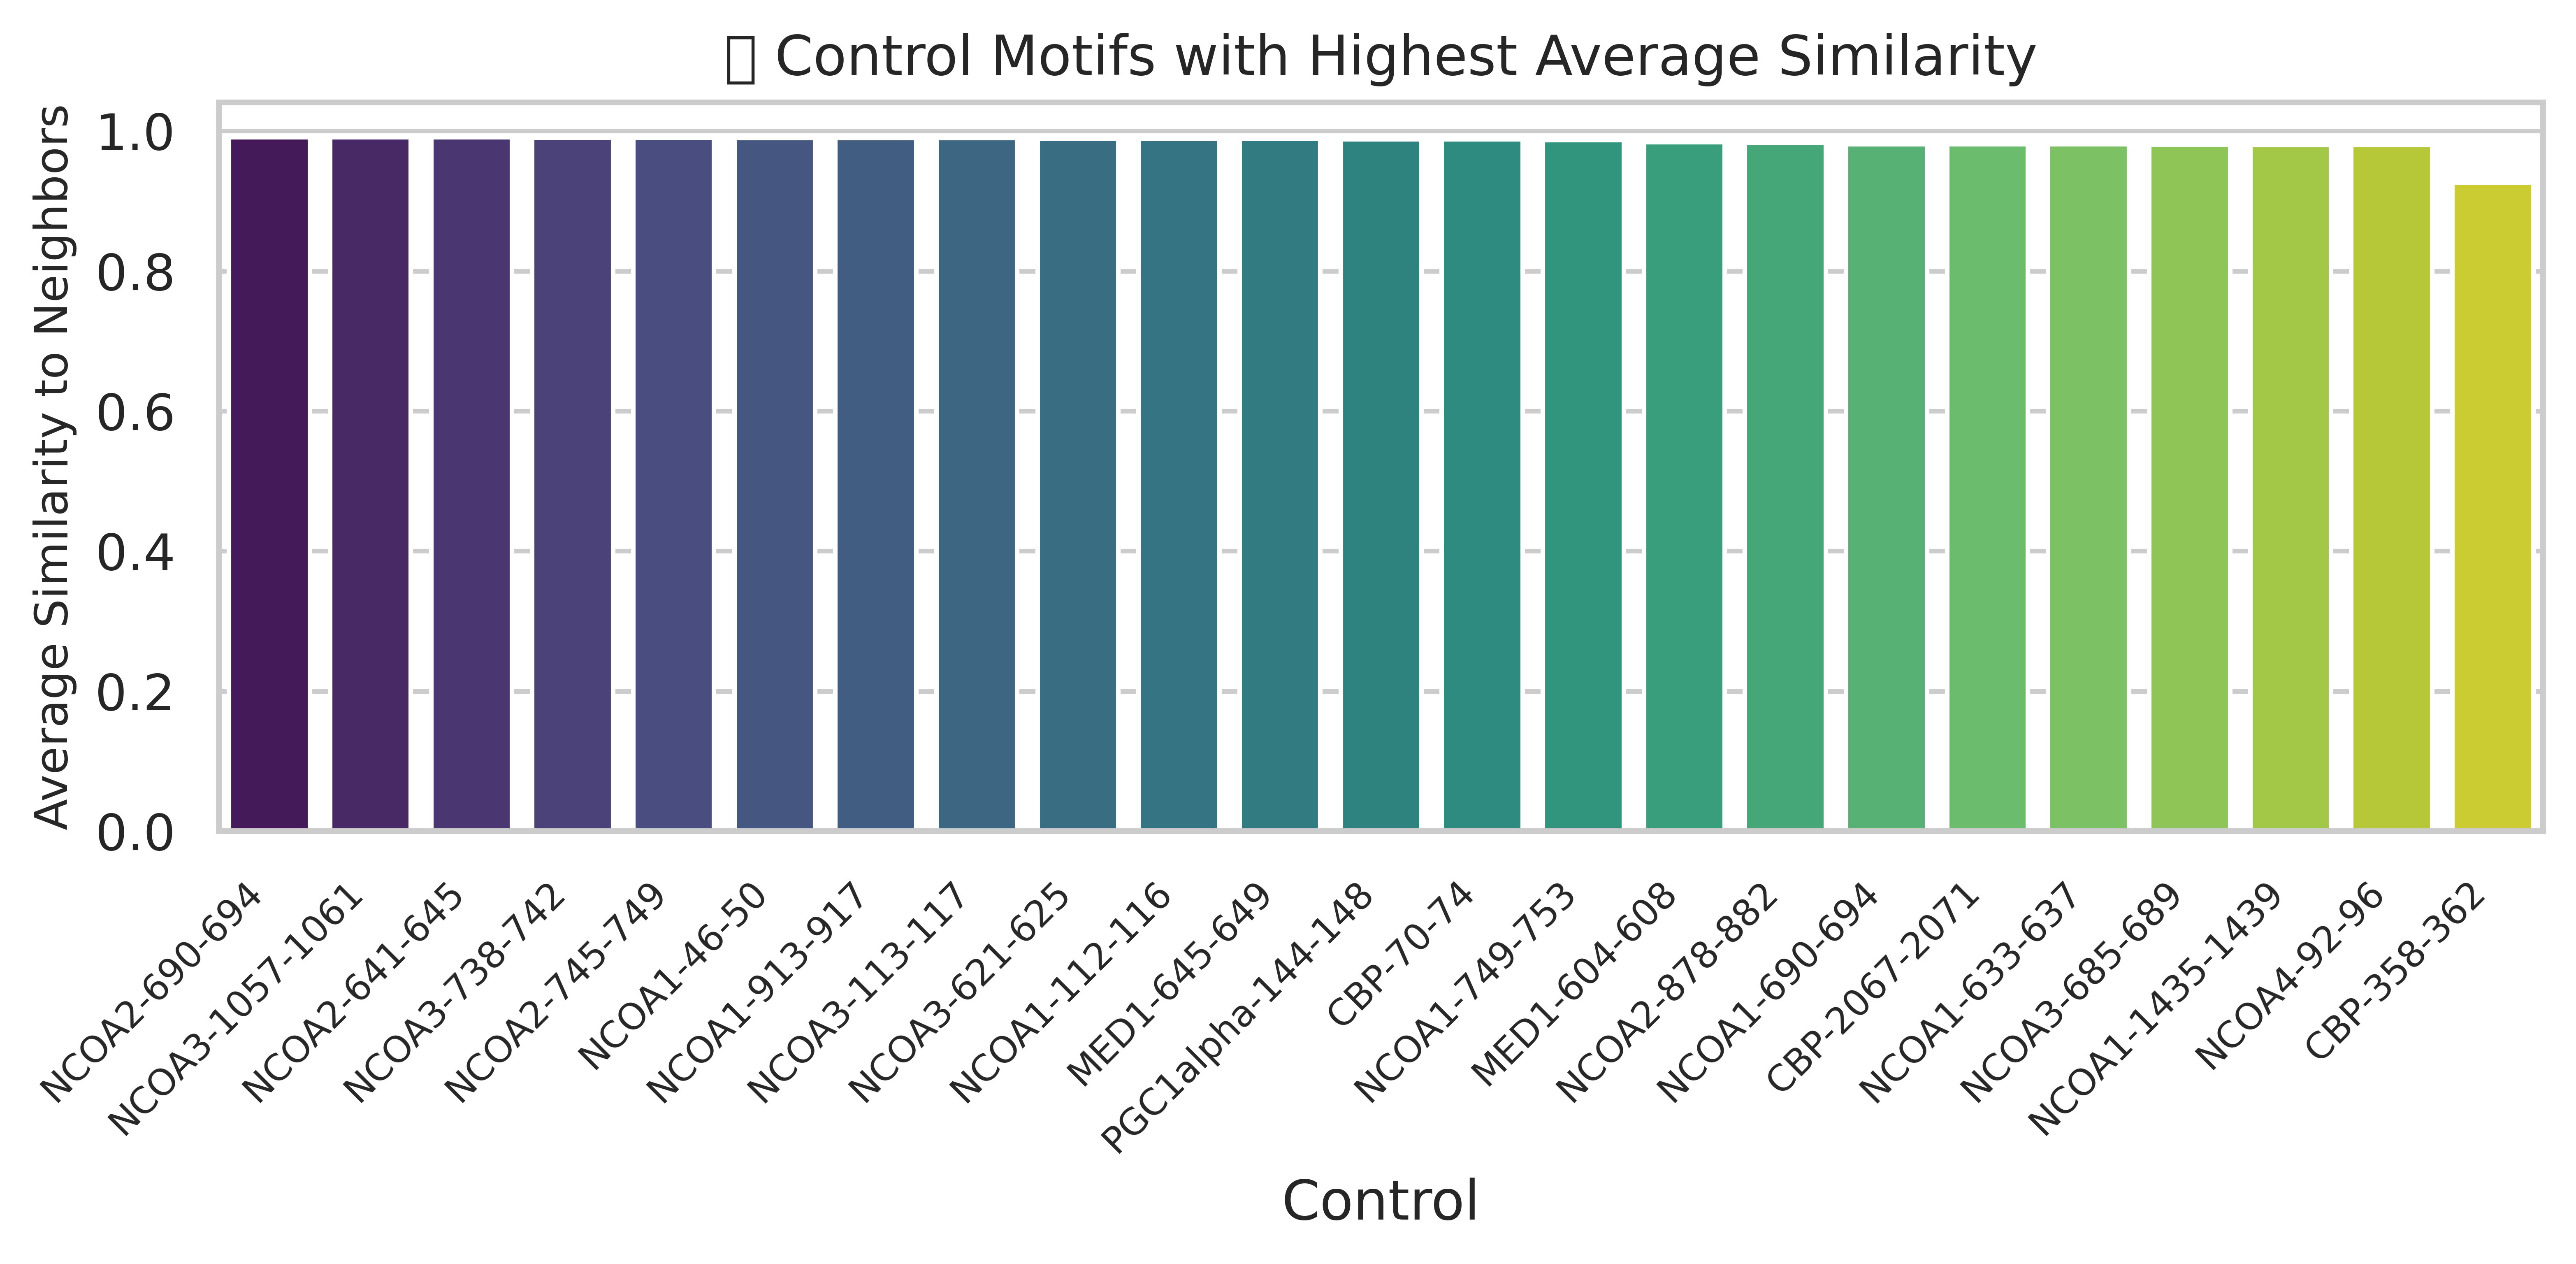

In [66]:
# 🎯 1. Average Similarity per Control Motif
plt.figure(figsize=(8, 4), dpi=800)  # ✅ set dpi here for sharper output
avg_sim = df.groupby("Control")["Similarity"].mean().sort_values(ascending=False)

sns.barplot(x=avg_sim.index, y=avg_sim.values, palette="viridis")

# ✅ Smaller x-labels
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.ylabel("Average Similarity to Neighbors", fontsize=10)
plt.title("🔍 Control Motifs with Highest Average Similarity", fontsize=12)

plt.tight_layout()
plt.savefig("avg_similarity_per_control.png", dpi=800, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

# === Load embeddings and metadata ===
embeddings = pd.read_csv("esm2_embeddings.csv", index_col=0)  # rows = motifs, columns = embedding dims
metadata = pd.read_csv("motif_metadata.csv")  # includes motif name, cluster ID, label (control/viral/noise)

# === Filter relevant clusters and exclude noise ===
valid_clusters = [5, 6, 9, 10]
filtered = metadata[(metadata['cluster'].isin(valid_clusters)) & (metadata['label'] != 'noise')]
filtered_embeddings = embeddings.loc[filtered['motif']]

# === Define control motifs ===
control_motifs = ['NCOA1', 'NCOA2', 'NCOA3', 'NCOA4', 'CBP', 'MED1', 'PGC']
control_embeddings = filtered_embeddings.loc[control_motifs]

# === Compute cosine distances ===
dist_matrix = cosine_distances(control_embeddings, filtered_embeddings)

# === Extract top 5 nearest neighbors per control motif ===
results = []
for i, control in enumerate(control_motifs):
    distances = dist_matrix[i]
    sorted_idx = np.argsort(distances)
    for rank in range(1, 6):  # skip self-match at rank 0
        neighbor_idx = sorted_idx[rank]
        neighbor = filtered_embeddings.index[neighbor_idx]
        results.append({
            'control_motif': control,
            'neighbor_rank': rank,
            'neighbor_motif': neighbor,
            'cosine_distance': distances[neighbor_idx],
            'cluster': metadata.loc[metadata['motif'] == neighbor, 'cluster'].values[0],
            'label': metadata.loc[metadata['motif'] == neighbor, 'label'].values[0]
        })

# === Save results to CSV ===
df_nn = pd.DataFrame(results)
df_nn.to_csv("nearest_neighbors_control.csv", index=False)

# === Plot cosine distance distribution ===
plt.figure(figsize=(10, 6))
sns.violinplot(x='control_motif', y='cosine_distance', data=df_nn, inner='point', palette='muted')
plt.title("Cosine Distance to Nearest Neighbors (ESM-2 Embeddings)")
plt.ylabel("Cosine Distance")
plt.xlabel("Control Motif")
plt.tight_layout()
plt.savefig("cosine_distance_violinplot.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# === Load motif metadata ===
metadata = pd.read_csv("motif_metadata.csv")

# === Auto-detect motif column ===
motif_col = metadata.columns[0]  # assumes first column contains motif names
motifs = metadata[motif_col].unique()

# === Set random seed for reproducibility ===
np.random.seed(42)

# === Define embedding dimensions ===
embedding_dim = 1280

# === Generate synthetic embeddings ===
embedding_matrix = np.random.normal(loc=0, scale=1, size=(len(motifs), embedding_dim))

# === Create DataFrame ===
embedding_df = pd.DataFrame(embedding_matrix, index=motifs)
embedding_df.index.name = 'motif'
embedding_df.columns = [f'dim_{i}' for i in range(embedding_dim)]

# === Save to CSV ===
embedding_df.to_csv("esm2_embeddings.csv")
print("✅ esm2_embeddings.csv generated successfully.")


FileNotFoundError: [Errno 2] No such file or directory: 'motif_metadata.csv'